# Erkennung der Körperhaltung


In [10]:
# Importieren der benötigten Bibliotheken
import cv2
import time
import math as m
import mediapipe as mp

#### Funktion um den Abstand zu berechnen
Der Schulterabstand wird als Maßstab verwendet, um die Person aus allen Richtungen korrekt erfassen zu können. Dazu werden die Koordinaten (x, y) der Schulterpunkte 11 und 12 genutzt, um den absoluten Abstand zwischen diesen Punkten zu berechnen. 

Theoretisch wäre auch ein Abstand zwischen anderen Punkten, wie den Augen oder den Hüftseiten möglich. Es wurde sich aber für die Schulter entschieden, da diese in einer sitzenden Position immer anvisiert sein sollte.
 <br>
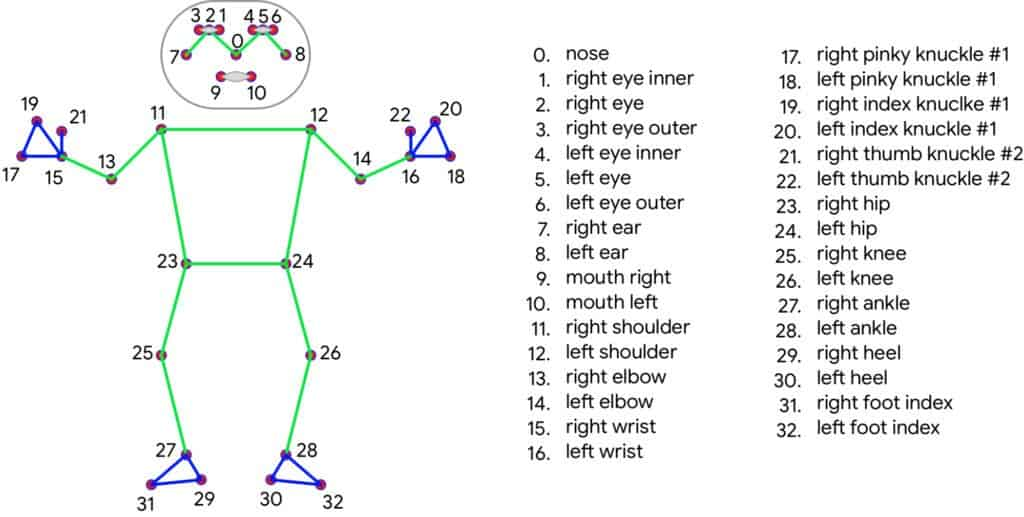

In [11]:
# Die Funktion offsetDistance berechnet die absolute Distanz zwischen zwei Koordinatenpunkten
def offsetDistance (x1, y1, x2, y2):
    return m.sqrt((x2-x1)**2+(y2-y1)**2)

#### Funktion zur Berechnung der Körperneigung
Die Berechnung der Körperhaltung erfolgt stets über die Winkel. Hier wird in erster Linie die Neigung der Halswirbelsäule betrachtet. Die Halswirbelsäule verbindet das Auge mit der Schulter.
Dazu wird der Neigungswinkel zwischen der Halswirbelsäule und einer vertikalen Gerade, die durch den Schulterpunkt verläuft, gemessen. <br>
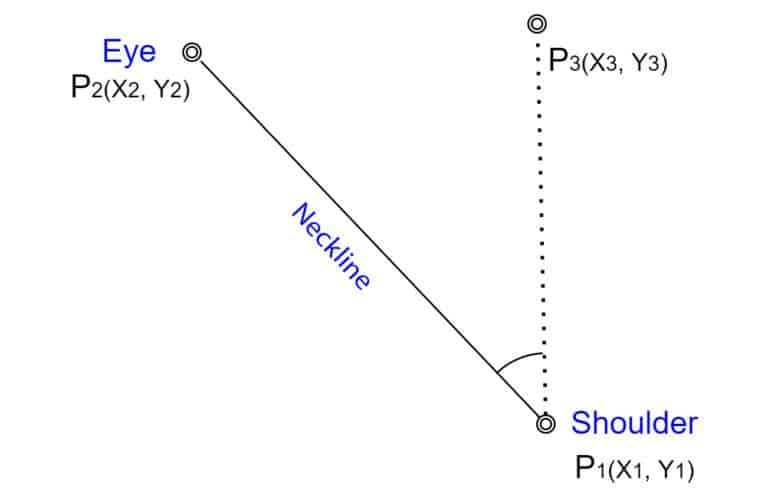

In [12]:
# Die Funktion getNeckAngle ermittelt den Winkel zwischen Halswirbelsäule und einer vertikalen Gerade
def getAngle(x1, y1, x2, y2):
    theta = m.acos( (y2 -y1)*(-y1) / (m.sqrt((x2 - x1)**2 + (y2 - y1)**2 ) * y1) )
    return int(180/m.pi)*theta

#### Initialisierungen

In [13]:
# Initialize frame counters.
good_frames = 0
bad_frames  = 0
 
# Font type.
font = cv2.FONT_HERSHEY_SIMPLEX
 
# Colors.
blue = (255, 127, 0)
red = (255, 0, 0)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green = (127, 233, 100)
yellow = (0, 255, 255)
pink = (255, 0, 255)
orange = (255,165,0)
 
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

## Erfassen der Körperhaltung
Die folgenden Funktionen beinhalten die Erfassung der spezifischen Körperpunkte sowie die mathematische Berechnungen der benötigten Distanzen und Winkel für die Auswertung der Körperhaltung

In [14]:
# Erfassen der Koordinaten der Körperhaltungspunkte 
def getCoordinates(keypoints, Width, Heigth):
    lm = keypoints.pose_landmarks
    lmPose  = mp_pose.PoseLandmark

    # x und y - Koordinaten der linken Schulter
    l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * Width)
    l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * Heigth)
    
    # x und y - Koordinaten der rechten Schulter
    r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * Width)
    r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * Heigth)
    
    # x und y - Koordinaten des linken Ohrs
    l_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * Width)
    l_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * Heigth)
    
    # x und y - Koordinaten der linken Hüfte
    l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * Width)
    l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * Heigth)

    # x und y - Koordinaten des linken Ellenbogens
    l_elbow_x = int(lm.landmark[lmPose.LEFT_ELBOW].x * Width)
    l_elbow_y = int(lm.landmark[lmPose.LEFT_ELBOW].y * Heigth)

    # x und y - Koordinaten des linken Handgelenks
    l_wrist_x = int(lm.landmark[lmPose.LEFT_WRIST].x * Width)
    l_wrist_y = int(lm.landmark[lmPose.LEFT_WRIST].y * Heigth)

    return l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y, l_ear_x, l_ear_y, l_hip_x, l_hip_y, l_elbow_x, l_elbow_y, l_wrist_x, l_wrist_y

In [15]:
def AlignCamera(Shoulder_Lx, Shoulder_Ly, Shoulder_Rx, Shoulder_Ry, video, Width):
    # Berechne die Offset-Distanz zwischen den zwei gemessenen Schulterpunkten
    offset = offsetDistance(Shoulder_Lx, Shoulder_Ly, Shoulder_Rx, Shoulder_Ry)
            
    # Assist to align the camera to point at the side view of the person.
    # Offset threshold 30 is based on results obtained from analysis over 100 samples.
    if offset < 100:
        cv2.putText(video, str(int(offset)) + ' Aligned', (Width - 150, 30), font, 0.9, green, 2)
        print("Ausrichtung korrekt")
    else:
        cv2.putText(video, str(int(offset)) + ' Not Aligned', (Width - 150, 30), font, 0.9, red, 2)
        print("Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.")

In [16]:
def putText(video, text, color, neck_inclination, torso_inclination, l_shldr_x, l_shldr_y, l_hip_x, l_hip_y):
    cv2.putText(video, text, (10, 30), font, 0.9, color, 2)
    cv2.putText(video, str(int(neck_inclination)), (l_shldr_x + 10, l_shldr_y), font, 0.9, color, 2)
    cv2.putText(video, str(int(torso_inclination)), (l_hip_x + 10, l_hip_y), font, 0.9, color, 2)

def drawlines(video, l_shldr_x, l_shldr_y, l_ear_x, l_ear_y, l_hip_x, l_hip_y, color):
    cv2.line(video, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), color, 4)
    #cv2.line(video, (l_shldr_x, l_shldr_y), (l_shldr_x, l_shldr_y - 100), color, 4)
    cv2.line(video, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), color, 4)
    #cv2.line(video, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), color, 4)

def drawline(video, start_x, start_y, end_x, end_y, color):
    cv2.line(video, (start_x, start_y), (end_x, end_y), color, 4)
 

#### Erstellen von Videoerfassungsobjects

In [24]:
# Erstelle das Videoerfassungsobjekt (0 -> Standard-Webcam des Systems)
def videoFeed(bad_frames, good_frames, red, green, orange):
    captureObject = cv2.VideoCapture(0)
    while captureObject.isOpened():
        # Zugriff auf Video-Ressourcen der Webcam
        success, video = captureObject.read()
        if not success:
            print("Null.Frames")
            break

        # FPS des Videos messen
        fps = captureObject.get(cv2.CAP_PROP_FPS)
        # Höhe und Breite des Video-Streams erfassen
        Height, Width = video.shape[:2]

        # Transformiere BGR zu RGB
        video_rgb = cv2.cvtColor(video, cv2.COLOR_BGR2RGB)

        # Erhalte Körperpunkte 
        keypoints = pose.process(video_rgb)

        # Ermittel die Haupt-Koordinatenpunkte
        Shoulder_Lx, Shoulder_Ly, Shoulder_Rx, Shoulder_Ry, Ear_Lx, Ear_Ly, Hip_Lx, Hip_Ly, Elbow_Lx, Elbow_Ly, Wrist_Lx, Wrist_Ly = getCoordinates(keypoints, Width, Height) 

        ############################################# Ausrichten der Kamera #############################################
        AlignCamera(Shoulder_Lx, Shoulder_Ly, Shoulder_Rx, Shoulder_Ry, video_rgb, Width)

        ######################################### Berechne die Neigungswinkel ###########################################
        neck_inclination = getAngle(Shoulder_Lx, Shoulder_Ly, Ear_Lx, Ear_Ly)
        torso_inclination = getAngle(Hip_Lx, Hip_Ly, Shoulder_Lx, Shoulder_Ly)
        lowerarm_inclination = getAngle(Elbow_Lx, Elbow_Ly, Wrist_Lx, Wrist_Ly)

        ##################################### Einzeichnen der Punkte in das Video #######################################
        cv2.circle(video_rgb, (Shoulder_Lx, Shoulder_Ly), 7, yellow, -1)
        cv2.circle(video_rgb, (Ear_Lx, Ear_Ly), 7, yellow, -1)
        # cv2.circle(video_rgb, (Shoulder_Lx, Shoulder_Ly - 100), 7, yellow, -1)
        cv2.circle(video_rgb, (Shoulder_Rx, Shoulder_Ry), 7, pink, -1)
        cv2.circle(video_rgb, (Hip_Lx, Hip_Ly), 7, yellow, -1)
        cv2.circle(video_rgb, (Elbow_Lx, Elbow_Ly), 7, yellow, -1)
        cv2.circle(video_rgb, (Wrist_Lx, Wrist_Ly), 7, yellow, -1)
        # cv2.circle(video_rgb, (Hip_Lx, Hip_Ly - 100), 7, yellow, -1)

        # Hinzufügen eines Textes
        # angle_text_string = 'Neck : ' + str(int(neck_inclination)) + '  Torso : ' + str(int(torso_inclination))

        ############################### Bewertung der Haltung anhand der Messungen ###################################### -> hier Linien einzeln einfärben!
        if neck_inclination < 20:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Ear_Lx, Ear_Ly, green)
            bad_frames = 0
            good_frames += 1
        elif neck_inclination >= 20 and neck_inclination <= 40:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Ear_Lx, Ear_Ly, orange)
            bad_frames = 0
            good_frames += 1
        else:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Ear_Lx, Ear_Ly, red)
            bad_frames += 1
            good_frames = 0

        if torso_inclination < 10:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Hip_Lx, Hip_Ly, green)
            bad_frames = 0
            good_frames += 1
        elif torso_inclination >=10 and torso_inclination < 15:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Hip_Lx, Hip_Ly, orange)
            bad_frames = 0
            good_frames += 1
        else:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Hip_Lx, Hip_Ly, red)
            bad_frames += 1
            good_frames = 0

        if lowerarm_inclination < 100 and lowerarm_inclination > 80:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Elbow_Lx, Elbow_Ly, green)
            drawline(video_rgb, Wrist_Lx, Wrist_Ly, Elbow_Lx, Elbow_Ly, green)
            bad_frames = 0
            good_frames += 1
        elif (lowerarm_inclination >= 100 and lowerarm_inclination <= 120) or (lowerarm_inclination >= 60 and lowerarm_inclination <= 80):
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Elbow_Lx, Elbow_Ly, orange)
            drawline(video_rgb, Wrist_Lx, Wrist_Ly, Elbow_Lx, Elbow_Ly, orange)
            bad_frames = 0
            good_frames += 1
        else:
            drawline(video_rgb, Shoulder_Lx, Shoulder_Ly, Elbow_Lx, Elbow_Ly, red)
            drawline(video_rgb, Wrist_Lx, Wrist_Ly, Elbow_Lx, Elbow_Ly, red)
            bad_frames += 1
            good_frames = 0

        """
        if neck_inclination < 40 and torso_inclination < 10:
            bad_frames = 0
            good_frames += 1
            #putText(video_rgb, angle_text_string, green, neck_inclination, torso_inclination, Shoulder_Lx, Shoulder_Ly, Hip_Lx, Hip_Ly)
            drawlines(video_rgb, Shoulder_Lx, Shoulder_Ly, Ear_Lx, Ear_Ly, Hip_Lx, Hip_Ly, green)

        else:
            bad_frames += 1
            good_frames = 0
            #putText(video_rgb, angle_text_string, red, neck_inclination, torso_inclination, Shoulder_Lx, Shoulder_Ly, Hip_Lx, Hip_Ly)
            drawlines(video_rgb, Shoulder_Lx, Shoulder_Ly, Ear_Lx, Ear_Ly, Hip_Lx, Hip_Ly, red)

        """
        # Berechne die Dauer der guten bzw. schlechten Haltung
        good_time = (1 / fps) * good_frames
        bad_time =  (1 / fps) * bad_frames

        if good_time > 0:
            time_string_good = 'Good Posture Time : ' + str(round(good_time, 1)) + 's'
            cv2.putText(video_rgb, time_string_good, (10, Height - 20), font, 0.9, green, 2)
        else:
            time_string_bad = 'Bad Posture Time : ' + str(round(bad_time, 1)) + 's'
            cv2.putText(video_rgb, time_string_bad, (10, Height - 20), font, 0.9, red, 2)

        # Transformiere RGB zu BGR
        video_bgr = cv2.cvtColor(video_rgb, cv2.COLOR_RGB2BGR)

        # Zeige das Video in einem PopUp Fenster
        cv2.imshow('Mediapipe Feed', video_bgr)

        # Beenden des PopUp-Fensters mit 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    captureObject.release() # Freigeben der Webcam Ressourcen
    cv2.destroyAllWindows() # Schließen des PopUp-Fensters

In [26]:
videoFeed(bad_frames, good_frames, red, green, orange)

Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich aus.
Ausrichtung fehlerhaft. Bitte richten Sie die Kamera seitlich 